In [2]:
import cv2
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
import random
import time

In [3]:
def read_mri_image(filename):
    '''Utility function to read MRI image,
    as a numpy array'''
    
    img = nib.load(filename)
    return img.get_data()

image_files = []

def load_files(path):
    '''Recursively goes into the path to extract all NIFTI image filenames. 
    Defaced and Undefaced MRI images are treated alike.'''
    
    if path.endswith('nii.gz'):
#         print(path)
        image_files.append(path)
    elif os.path.isdir(path):
        for file in os.listdir(path):
            load_files(os.path.join(path,file))

In [4]:
# Recursively extracts relevant filenames from the path specified
path = '../mri_data/small_set'
load_files(path)
print('Total Number of Images :', len(image_files))

Total Number of Images : 38


In [6]:
# Shuffles and splits the image files into train and validation set
random.shuffle(image_files)
split = int(0.8*len(image_files))
train_files, val_files = image_files[:split], image_files[split:]
print('Number of train images :', len(train_files))
print('Number of test images :', len(val_files))

Number of train images : 30
Number of test images : 8


In [8]:
# Acts as a cache for train dataset

train_dim_0 = np.empty(len(train_files), dtype=object)
train_dim_1 = np.empty(len(train_files), dtype=object)
train_dim_2 = np.empty(len(train_files), dtype=object)

train_y = list()

def read_files_batch(files, start):
    '''Reads MRI images batch by batch. All defaced images are identified by a "deface" in the file name. 
    This function was needed due to certain unknown errors in the GPU cluster'''
    
    e = start
    for f in files:
        img = read_mri_image(f)
        m0 = np.mean(img,axis=0)
        m1 = np.mean(img,axis=1)
        m2 = np.mean(img,axis=2)
        train_dim_0[e] = m0
        train_dim_1[e] = m1
        train_dim_2[e] = m2
        e+=1
        if 'deface' in f:
            train_y.append(1)
        else:
            train_y.append(0) 
            
start = time.time()

batch_size = 20
for i in range(0,len(train_files),batch_size):
    if i+batch_size > len(train_files):
        read_files_batch(train_files[i:], i)
    else:
        print(i, " Done")
        read_files_batch(train_files[i:i+batch_size], i)
        
print("Training set ready")

# Acts as a cache for validation dataset

val_dim_0 = np.empty(len(val_files), dtype=object)
val_dim_1 = np.empty(len(val_files), dtype=object)
val_dim_2 = np.empty(len(val_files), dtype=object)

val_y = list()

for e, f in enumerate(val_files):
    img = read_mri_image(f)
    m0 = np.mean(img,axis=0)
    m1 = np.mean(img,axis=1)
    m2 = np.mean(img,axis=2)
    val_dim_0[e] = m0
    val_dim_1[e] = m1
    val_dim_2[e] = m2

    if 'deface' in f:
        val_y.append(1)
    else:
        val_y.append(0)

    if e%100==0:
        print (e," done")

print("Val set ready")

print("Time taken : ", time.time()-start)

0  Done
Training set ready
0  done
Val set ready
Time taken :  7.201429605484009


In [16]:
from keras import layers, models

def Conv_BN_RELU(x, filters=32, kernel=3, strides=1, padding='same'):
    '''Helper to create a modular unit containing Convolution, BatchNormalizaton and Activation'''
    
    x = layers.Conv2D(filters,kernel,strides=strides,padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def create_submodel():
    '''The feature extracting submodel for which shares parameters'''

    inp = layers.Input(shape=(None,None,1))

    conv1 = Conv_BN_RELU(inp, filters=8, kernel=5, strides=4, padding='same')

    conv2 = Conv_BN_RELU(conv1, filters=16, kernel=5, strides=1, padding='same')
    conv2 = Conv_BN_RELU(conv2, filters=16, kernel=2, strides=2, padding='same')

    conv3 = Conv_BN_RELU(conv2, filters=24, kernel=5, strides=1, padding='same')
    conv3 = Conv_BN_RELU(conv3, filters=24, kernel=2, strides=2, padding='same')

    conv4 = Conv_BN_RELU(conv2, filters=32, kernel=5, strides=1, padding='same')
    conv4 = Conv_BN_RELU(conv3, filters=32, kernel=2, strides=2, padding='same')

    out = layers.GlobalAveragePooling2D()(conv4)

    model = models.Model(inp,out)

    print(model.summary())

    return model

def create_model():
    '''Assembles all the submodels into a unified single model'''

    inp1 = layers.Input(shape=(None,None,1), name='input_1')
    inp2 = layers.Input(shape=(None,None,1), name='input_2')
    inp3 = layers.Input(shape=(None,None,1), name='input_3')

    submodel = create_submodel()

    one = submodel(inp1)
    two = submodel(inp2)
    three = submodel(inp3)

    concat = layers.Concatenate()([one,two,three])
    dropout = layers.Dropout(0.5)(concat)
    out = layers.Dense(1,activation='sigmoid',name='output_node')(dropout)

    return models.Model(inputs=[inp1,inp2,inp3],outputs=out)

In [17]:
# Create and compile Keras model
model = create_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     208       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 8)     32        
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 8)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 16)    3216      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, None, None, 16)    0         
__________

In [10]:
import imgaug as ia
from imgaug import augmenters as iaa

def augment(images, target_size=None):
    '''Function for augmenting MRI images while training, to increase generalization'''

    sometimes = lambda aug : iaa.Sometimes(0.2,aug)

    # The commented augmentations sometimes destroyed the image. Need to discuss which ones are appropriate here

    seq = iaa.Sequential([
        sometimes(iaa.GaussianBlur(sigma=(0.0,2.0))),
#         sometimes(iaa.ContrastNormalization((0.9,1.1))),
#         sometimes(iaa.Multiply((0.95,1.05))),
#         iaa.Sharpen(alpha=(0, 0.5), lightness=(0.9, 1.1)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),

        iaa.OneOf([
            iaa.Affine(rotate=(90)),
            iaa.Affine(rotate=(-90)),
            iaa.Affine(rotate=(0))
        ])
    ])

    float_images = []

    if target_size:
        for j in range(len(images)):
            img = images[j]
            # print(img)
            if img is None:
                 print("ohno")
            else:
                float_images.append(cv2.resize(img.astype('float'), target_size))

    seq_det = seq.to_deterministic()
    aug_images = seq_det.augment_images(float_images)

    aug_images = np.expand_dims(aug_images, axis=3)

    return aug_images




In [11]:
# def batch_read(image_files):
#       '''Needed if images are to be batch read, while training the model'''

#     dim_0 = np.empty(len(image_files),dtype=object)
#     dim_1 = np.empty(len(image_files),dtype=object)
#     dim_2 = np.empty(len(image_files),dtype=object)

#     batch_y = list()

#     for e,img_f in enumerate(image_files):

#         img = read_mri_image(img_f)
#         m0 = np.mean(img,axis=0)
#         m1 = np.mean(img,axis=1)
#         m2 = np.mean(img,axis=2)
#         dim_0[e] = m0
#         dim_1[e] = m1
#         dim_2[e] = m2

#         if 'deface' in img_f:
#             batch_y.append(1)
#         else:
#             batch_y.append(0)

#     dim_0 = augment(dim_0)
#     dim_1 = augment(dim_1)
#     dim_2 = augment(dim_2)

#     return ([dim_0, dim_1, dim_2], np.array(batch_y))

In [12]:
def generator(batch_size, train=True):
    '''Generator for feeding the model while training'''

    sizes = [(64,64),(128,128),(192,192),(256,256)]

    while True:

        if train:
            for i in range(0, len(train_files), batch_size):

                batch_x_0 = augment(train_dim_0[i:i+batch_size], target_size=random.choice(sizes))
                batch_x_1 = augment(train_dim_1[i:i+batch_size], target_size=random.choice(sizes))
                batch_x_2 = augment(train_dim_2[i:i+batch_size], target_size=random.choice(sizes))
               # batch_x_0 = np.expand_dims([train_dim_0[i].astype('float')], axis=3)
               # batch_x_1 = np.expand_dims([train_dim_1[i].astype('float')], axis=3)
               # batch_x_2 = np.expand_dims([train_dim_2[i].astype('float')], axis=3)
                batch_y = train_y[i:i+batch_size]

                yield ([batch_x_0, batch_x_1, batch_x_2], np.array(batch_y))

        else:
            for i in range(0, len(val_files), batch_size):

                batch_x_0 = np.expand_dims([val_dim_0[i].astype('float')], axis=3)
                batch_x_1 = np.expand_dims([val_dim_1[i].astype('float')], axis=3)
                batch_x_2 = np.expand_dims([val_dim_2[i].astype('float')], axis=3)

                batch_y = val_y[i:i+batch_size]

                yield ([batch_x_0, batch_x_1, batch_x_2], np.array(batch_y))



(128, 128, 1)


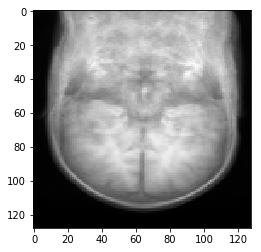

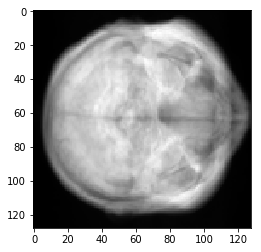

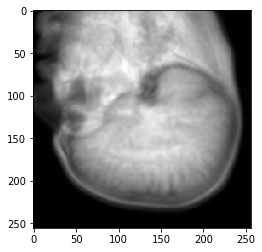

In [13]:
# Test to check generator

g = generator(4)
batch_x, batch_y = next(g)
print(batch_x[1][2].shape)

plt.imshow(np.squeeze(batch_x[0][0]), 'gray')
plt.show()

plt.imshow(np.squeeze(batch_x[1][0]), 'gray')
plt.show()

plt.imshow(np.squeeze(batch_x[2][0]), 'gray')
plt.show()

In [14]:
# Create necessary folders for logging and saving
os.makedirs('models',exist_ok=True)
os.makedirs('logs',exist_ok=True)

In [19]:
from keras.callbacks import ModelCheckpoint, CSVLogger

batch_size = 4

train_gen = generator(batch_size, train=True)
val_gen = generator(1, train=False)

checkpoint = ModelCheckpoint(filepath='models/model_best.h5', save_best_only=True, monitor='val_loss',
                             save_weights_only=False)

csv_logger = CSVLogger('logs/training.log')

# Training with checkpoints for saving and logging results
model.fit_generator(train_gen, steps_per_epoch=len(train_files)//batch_size,
                    validation_data=val_gen, validation_steps=len(val_files),
                    epochs=40, callbacks=[checkpoint, csv_logger])

# NOTE: The results below are just for a sample dataset

Epoch 1/40
7/7 [==============================] - 1s 178ms/step - loss: 0.6511 - acc: 0.6071 - val_loss: 0.7285 - val_acc: 0.3750
Epoch 2/40
7/7 [==============================] - 1s 129ms/step - loss: 0.6841 - acc: 0.6803 - val_loss: 0.7609 - val_acc: 0.5000
Epoch 3/40
7/7 [==============================] - 1s 141ms/step - loss: 0.6344 - acc: 0.6442 - val_loss: 0.6525 - val_acc: 0.6250
Epoch 4/40
7/7 [==============================] - 1s 138ms/step - loss: 0.6892 - acc: 0.4639 - val_loss: 0.6675 - val_acc: 0.6250
Epoch 5/40
7/7 [==============================] - 1s 127ms/step - loss: 0.5540 - acc: 0.6490 - val_loss: 0.6557 - val_acc: 0.5000
Epoch 6/40
7/7 [==============================] - 1s 122ms/step - loss: 0.6117 - acc: 0.7163 - val_loss: 0.6457 - val_acc: 0.6250
Epoch 7/40
7/7 [==============================] - 1s 137ms/step - loss: 0.5906 - acc: 0.7524 - val_loss: 0.6622 - val_acc: 0.6250
Epoch 8/40
7/7 [==============================] - 1s 112ms/step - loss: 0.6098 - acc: 0.64

KeyboardInterrupt: 

In [ ]:
# Save and load model
model.save('models/model_final.h5')

from keras.models import load_model
model = load_model('models/model_best.h5')